/Users/BenjaminSuter/opt/anaconda3/envs/python36/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/BenjaminSuter/opt/anaconda3/envs/python36/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


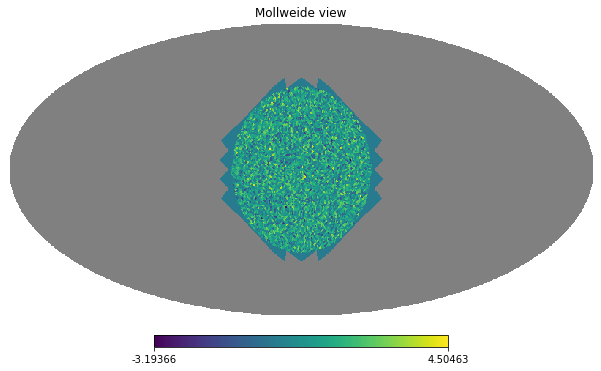

In [87]:
import tensorflow as tf
import numpy as np
import healpy as hp

from DeepSphere.utils import extend_indices
from DeepSphere import healpy_networks as hp_nn
from DeepSphere import gnn_layers
import matplotlib.pyplot as plt

%matplotlib inline

NSIDE = 64
NPIX = hp.nside2npix(NSIDE)

all_ipix = list(range(NPIX))
hp_map = np.zeros(NPIX)

# create a mask
pix = hp.query_disc(nside=NSIDE, vec=np.array([1.0, 0.0, 0.0]), radius=0.75)
hp_map[pix] = 1.0

hp_map_nest = hp.reorder(hp_map, r2n=True)
indices = np.arange(NPIX)[hp_map_nest > 0.5]

# With this first mask we might not be able to properly downsample to a wanted NSIDE
# so we extent the indices
indices_ext = extend_indices(indices=indices, nside_in=NSIDE, nside_out=8)

new_map = np.full(shape=(NPIX), fill_value=hp.UNSEEN)

for indice in indices_ext:
    new_map[indice] = 0.0
for indice in indices:
    new_map[indice] = np.random.normal(1)

hp.mollview(new_map, nest=True)

new_map = np.expand_dims(new_map, axis=0)
new_map = np.expand_dims(new_map, axis=-1)

# Now we'll try to implement custom training:

In [88]:
layers = [gnn_layers.HealpyPseudoConv(p=1, Fout=4, activation='elu'),
          gnn_layers.HealpyPseudoConv(p=1, Fout=4, activation='relu'),
          gnn_layers.HealpyPseudoConv(p=1, Fout=4, activation='elu'),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1)]

# build a model
batch_size = 32
tf.keras.backend.clear_session()
model = hp_nn.HealpyGCNN(nside=NSIDE, indices=indices_ext, layers=layers)

model.build(input_shape=(batch_size, len(indices_ext), 1))

Detected a reduction factor of 8, the input with nside 64 will be reduced to 8 during a forward pass. Checking for consistency with indices...
indices seem consistent...


In [89]:
# Define the loss and gradient function

# Again we will use the MeanAbsoluteError()
loss_object = tf.keras.losses.MeanAbsoluteError()


def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)
    
    return loss_object(y_true=y, y_pred=y_)

In [90]:
# Use the tf.GradientTape contex to calculate the gradients used
# to optimize the model.
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Setup the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.008)

In [91]:
# Build a training loop
# We want to generate the data on the fly.

# Define a mask with padding
tf_mask = np.ones((batch_size, len(indices_ext),1))
for index in range(len(indices_ext)):
    if not indices_ext[index] in indices:
        tf_mask[:,index,:] = 0.0

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
global_norm_results = []

num_epochs = 200

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    epoch_global_norm = []
    
    # Training loop - use batches of 500
    # Generate the data on the fly
    for i in range(32):
        training_labels = np.random.rand(batch_size).reshape((-1,1))
        training_maps = np.random.normal(size=(batch_size,len(indices_ext),1))

        # Shift mean
        for i in range(batch_size):
            training_maps[i,:,0] += training_labels[i,0]

        # Mask
        training_maps = tf_mask*training_maps.astype(np.float32)

        
        # Optimize the model
        loss_value, grads = grad(model, training_maps, training_labels)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Track progress
        epoch_loss_avg.update_state(loss_value) # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy.update_state(training_labels, model(training_maps, training=True))
        epoch_global_norm.append(tf.linalg.global_norm(grads))
        
    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    global_norm_results.append((sum(epoch_global_norm)/len(epoch_global_norm)))

        
    if epoch % 4 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 0.180
Epoch 004: Loss: 0.037
Epoch 008: Loss: 0.021
Epoch 012: Loss: 0.025
Epoch 016: Loss: 0.024
Epoch 020: Loss: 0.016
Epoch 024: Loss: 0.019
Epoch 028: Loss: 0.020
Epoch 032: Loss: 0.017
Epoch 036: Loss: 0.021
Epoch 040: Loss: 0.017
Epoch 044: Loss: 0.016
Epoch 048: Loss: 0.015
Epoch 052: Loss: 0.021
Epoch 056: Loss: 0.023
Epoch 060: Loss: 0.018
Epoch 064: Loss: 0.017
Epoch 068: Loss: 0.023
Epoch 072: Loss: 0.016
Epoch 076: Loss: 0.014
Epoch 080: Loss: 0.017
Epoch 084: Loss: 0.019
Ep

In [92]:
labels = np.random.rand(batch_size).reshape((-1,1))
maps = np.random.normal(size=(batch_size,len(indices_ext),1))

# Shift mean
for i in range(batch_size):
    maps[i,:,0] += labels[i,0]

# Mask
maps = tf_mask*maps.astype(np.float32)

predictions = model(maps)
for index in range(batch_size):
    print("Model predicted %f, true label is %s" % (predictions[index,:], labels[index,:]))

Model predicted 0.172818, true label is [0.17364788]
Model predicted 0.772152, true label is [0.79146942]
Model predicted 0.734674, true label is [0.76210008]
Model predicted 0.358283, true label is [0.3394037]
Model predicted 0.885273, true label is [0.93363542]
Model predicted 0.707619, true label is [0.74580063]
Model predicted 0.642871, true label is [0.67125282]
Model predicted 0.370381, true label is [0.37718193]
Model predicted 0.144819, true label is [0.14056844]
Model predicted 0.487865, true label is [0.49575454]
Model predicted 0.406957, true label is [0.40682389]
Model predicted 0.272841, true label is [0.26899714]
Model predicted 0.876772, true label is [0.88107755]
Model predicted 0.409000, true label is [0.38218266]
Model predicted 0.949053, true label is [0.96428033]
Model predicted 0.644559, true label is [0.65276008]
Model predicted 0.745479, true label is [0.76170775]
Model predicted 0.918189, true label is [0.93890057]
Model predicted 0.378257, true label is [0.3912

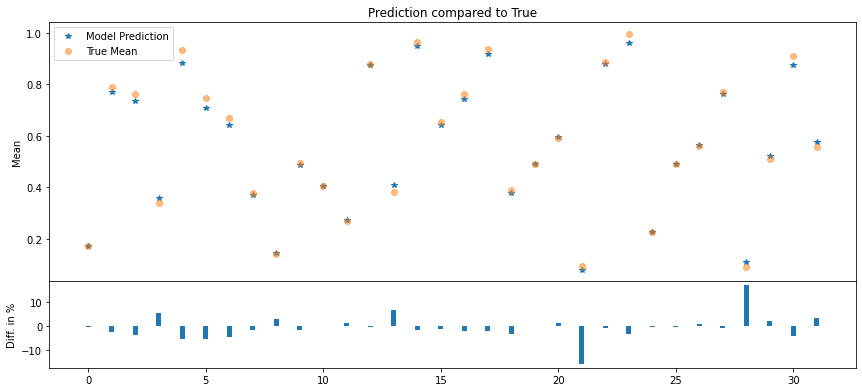

In [115]:
# Plot the prediction against the true label
steps = np.arange(32)
RelDiff = []
for index in steps:
    if predictions[index:0] < labels[index:0]:
        diff = (1 - predictions[index,0]/labels[index,0])*100
        print(diff)
    else:
        diff = (1 - labels[index,0]/predictions[index,0])*100
    RelDiff.append(diff)
# Calculate the % difference
#RelDiff
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_axes([0.1, 0.35, 0.8, 0.6],
                    ylabel='Mean',
                    title='Prediction compared to True')
ax2 = fig.add_axes([0.1, 0.15, 0.8, 0.2],
                    sharex=ax1,
                    ylabel='Diff. in %')

ax1.plot(predictions[:,0], marker='*', ls='',
                label='Model Prediction')
ax1.plot(labels[:,0], marker='o', ls='', alpha=0.5,
                label='True Mean')
ax2.bar(steps, RelDiff, width=0.2, label='Rel. Diff')
#plt.savefig(target, format='pdf')
ax1.legend()
plt.show()

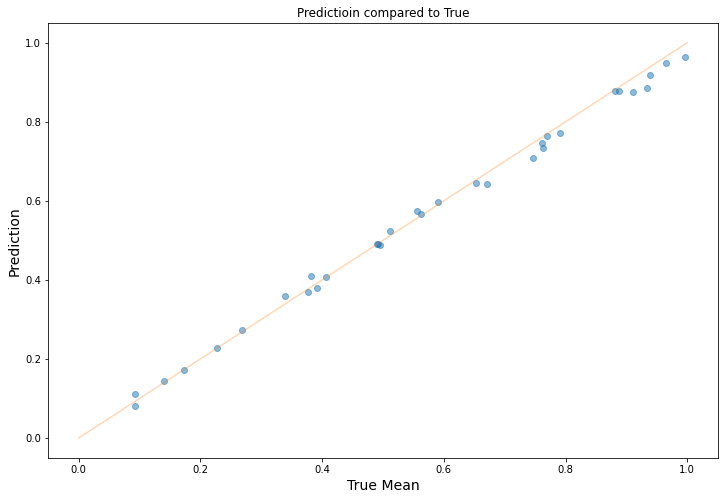

In [121]:
true_line = np.linspace(0,1,100)
plt.figure(figsize=(12,8))
plt.title('Predictioin compared to True')
plt.xlabel("True Mean", fontsize=14)
plt.ylabel("Prediction", fontsize=14)
plt.plot(labels[:,0], predictions[:,0], marker='o', alpha=0.5, ls='')
plt.plot(true_line,true_line, alpha=0.3)
plt.show()

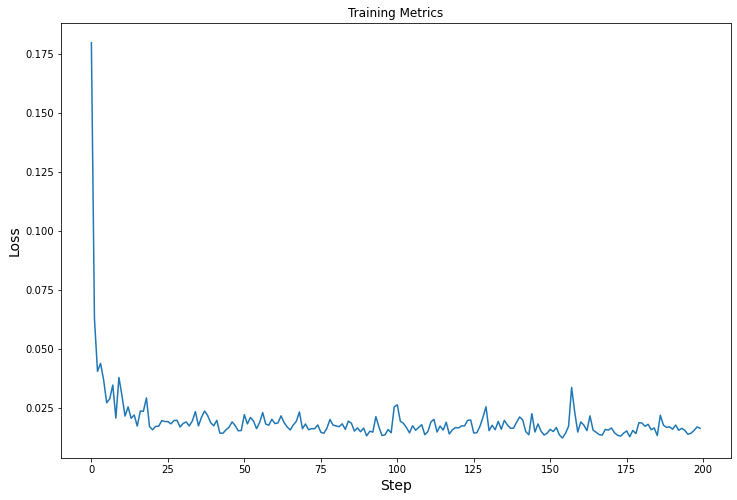

In [93]:
plt.figure(figsize=(12, 8))
plt.title('Training Metrics')

plt.ylabel("Loss", fontsize=14)
plt.plot(train_loss_results)
plt.xlabel("Step", fontsize=14)
plt.show()


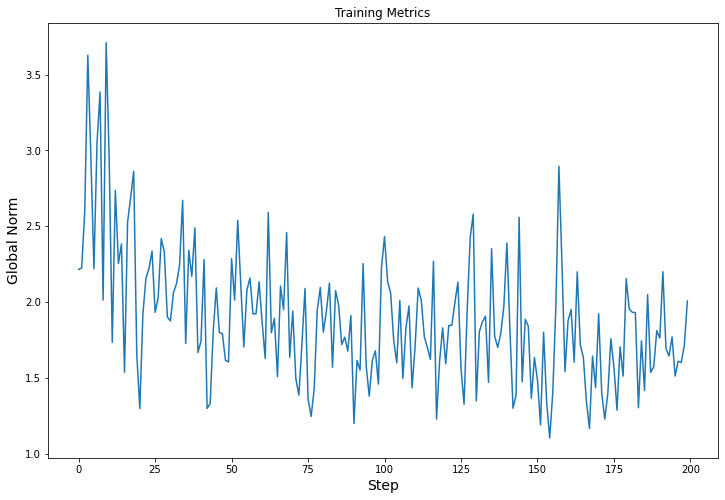

In [94]:
plt.figure(figsize=(12, 8))
plt.title('Training Metrics')

plt.ylabel("Global Norm", fontsize=14)
plt.plot(global_norm_results)
plt.xlabel("Step", fontsize=14)
plt.show()
